# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch

    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # Setup device
    device = torch.device('cuda' if use_cuda else 'cpu')

    # TODO: set the model to train mode
    model.train()

    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()

        # TODO: run the network
        output = model(data)

        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)

        # TODO: do backpropagation
        loss.backward()

        # TODO: optimize
        optimizer.step()

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
          print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()

            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0

                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)

                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())

                plotted += 1
                img_idx += 1

    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [7]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with sigmoid non-linearity

    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)

        # TODO: run network layers
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        x = self.fc5(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)

        return output

In [8]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with relu non-linearity

    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)

        return output

In [9]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with relu non-linearity and batch normalization for the first and third layers

    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.batch_norm1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.batch_norm2 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()

        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)

        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [ ]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers with batch normalization to first convolutional/fully connected layer

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

In [ ]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers with max pooling

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(4, 2)      # 32*26*26 -> 32*12*12
        self.conv2 = nn.Conv2d(32, 64, 1)      # 32*12*12 -> 64*12*12
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

In [5]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.59MB/s]


### Experiments
Here, we trained variants of MLP and CNN for **10 epochs** to explore the influence of activation functions, batch normalization, and pooling on model performance.

As observed from the results after 10 epochs:

* MLP with **sigmoid non-linearity**: 95.38%
* MLP with **ReLU non-linearity**: 98.33%
* MLP with **ReLU non-linearity** and **batch normalization**: 98.49%

* Plain CNN: 99.15%
* CNN with **batch normalization**: 99.19%
* CNN with **max pooling** and **batch normalization**: 99.23%

We can see that modern techniques such as the ReLU activation function and batch normalization provide performance improvements for both MLP and CNN models.

In the design of ConvNet3, we replaced the second convolution layer with a max pooling layer followed by a 1×1 convolution to reduce image size and the number of channels. This modification slightly improved accuracy after 10 epochs, suggesting that the translation invariance introduced by max pooling contributes to better performance.

#### Run MLP

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.270659
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.301718
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.339885
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.290579
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.299327
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.302014
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.292803
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.890486
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.637927
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.523925

Test set: Average loss: 1.5409, Accuracy: 3719/10000 (37.19%)



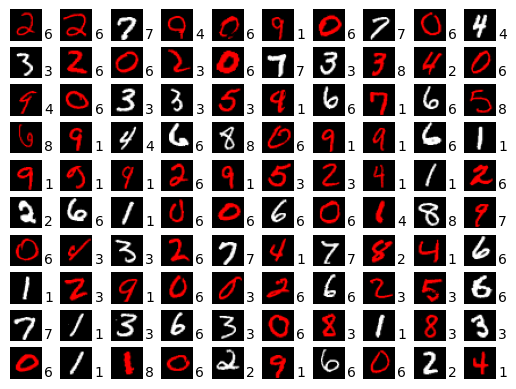

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.567135
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.444452
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.319340
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.284228
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.168453
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.294335
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.093822
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.285568
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.076460
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.068981

Test set: Average loss: 0.9469, Accuracy: 7198/10000 (71.98%)



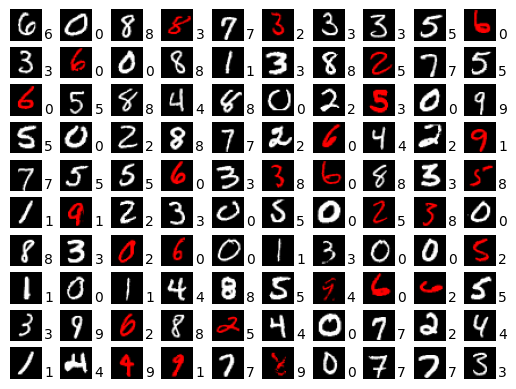

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.950050
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.792226
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.970859
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.682490
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.948181
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.623487
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.591295
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.485161
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.545942
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.878520

Test set: Average loss: 0.5572, Accuracy: 8613/10000 (86.13%)



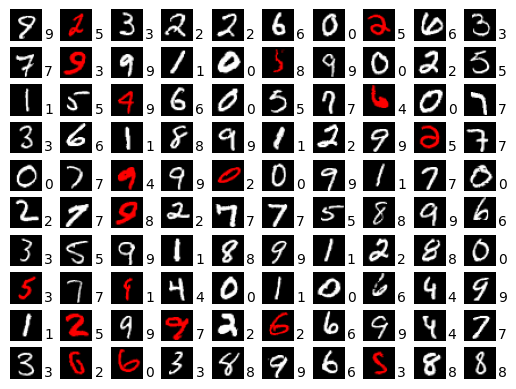

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.832553
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.313653
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.584117
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.402382
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.239327
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.359404
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.452565
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.322570
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.329439
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.542193

Test set: Average loss: 0.3594, Accuracy: 9104/10000 (91.04%)



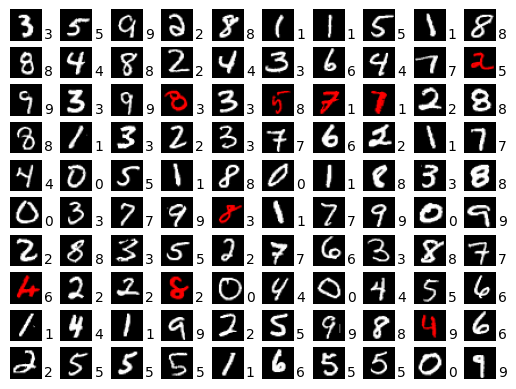

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.238800
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.567826
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.240678
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.229106
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.299720
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.173742
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.338078
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.603259
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.208964
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.120057

Test set: Average loss: 0.2586, Accuracy: 9410/10000 (94.10%)



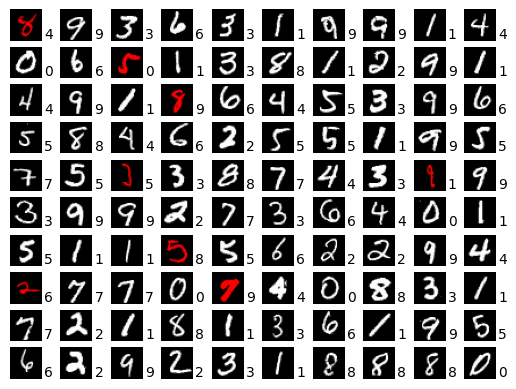

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.328794
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.573404
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.282446
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.343342
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.318694
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.131503
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.218459
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.238895
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.194118
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.197848

Test set: Average loss: 0.2318, Accuracy: 9462/10000 (94.62%)



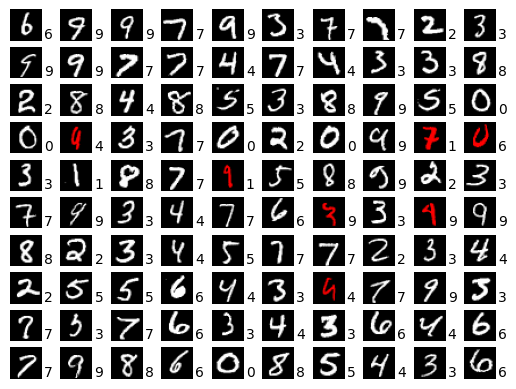

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.116042
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.144231
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.281740
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.083678
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.127277
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.168575
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.236227
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.064827
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.111760
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.105067

Test set: Average loss: 0.2135, Accuracy: 9490/10000 (94.90%)



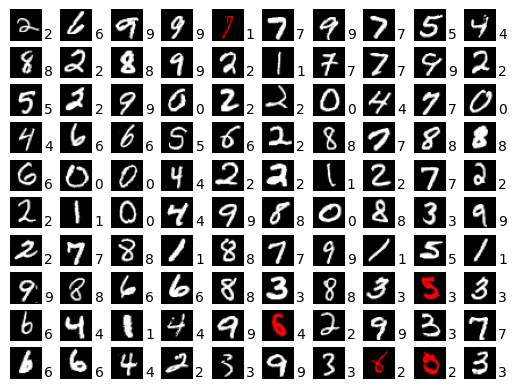

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.224309
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.161453
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.106731
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.056720
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.101909
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.194392
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.083231
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.270232
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.081932
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.122231

Test set: Average loss: 0.1977, Accuracy: 9528/10000 (95.28%)



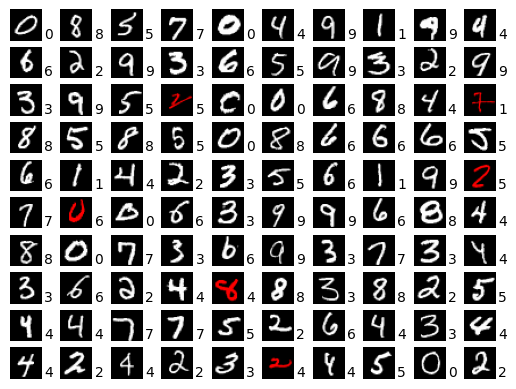

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.095268
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.090590
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.129706
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.243150
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.110055
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.199874
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.071967
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.090464
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.257591
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.116613

Test set: Average loss: 0.1948, Accuracy: 9531/10000 (95.31%)



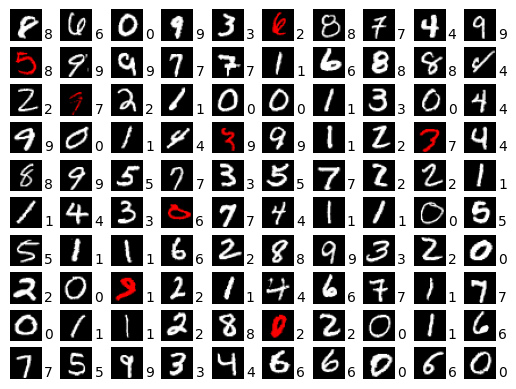

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.232810
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.125685
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.086971
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.126458
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.131394
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.094537
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.042380
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.344601
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.120150
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.076996

Test set: Average loss: 0.1913, Accuracy: 9538/10000 (95.38%)



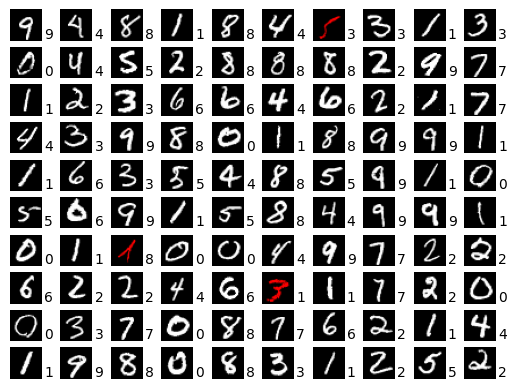

In [10]:
###=============================================================================
### Run MLP with sigmoid non-linearity (By 10 epochs accuracy: 95.38%)
###=============================================================================
model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293072
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.424527
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.388058
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.077561
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.361589
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.102967
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.144570
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.077278
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.087657
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.066239

Test set: Average loss: 0.1350, Accuracy: 9592/10000 (95.92%)



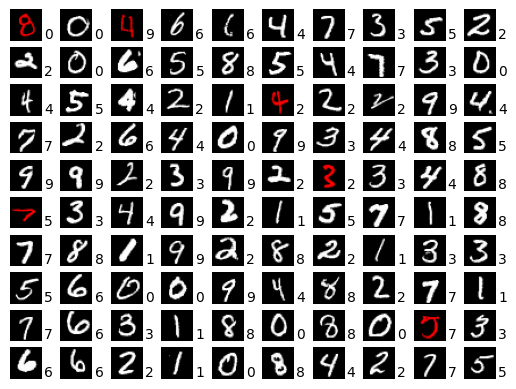

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.105711
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.095465
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293148
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.094396
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.076729
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.288455
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.254267
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.140761
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.047920
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.066911

Test set: Average loss: 0.0914, Accuracy: 9741/10000 (97.41%)



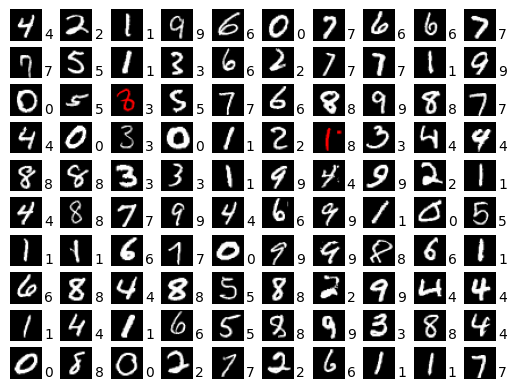

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.033732
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.019064
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.011206
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.129696
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.005664
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.011203
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.013052
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.008729
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.205663
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.098710

Test set: Average loss: 0.0833, Accuracy: 9777/10000 (97.77%)



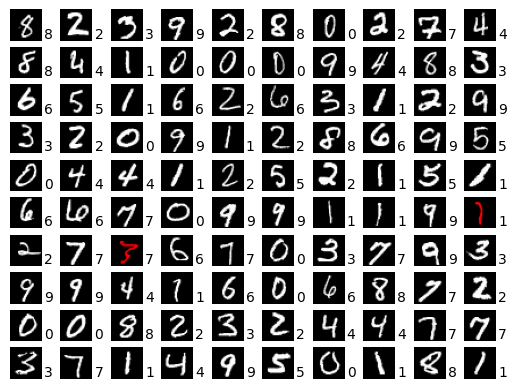

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.016009
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.009017
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.056809
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.093602
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.056201
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001486
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.004295
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.037250
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001321
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.004993

Test set: Average loss: 0.0788, Accuracy: 9789/10000 (97.89%)



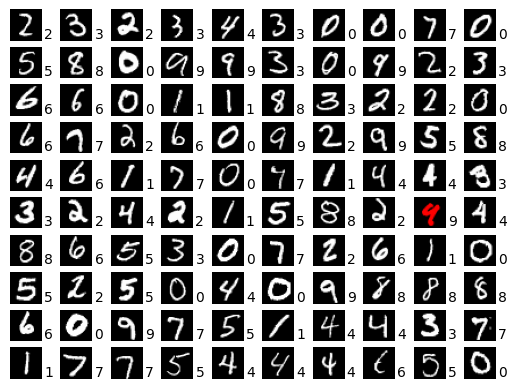

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011416
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000373
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.005665
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002553
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.093833
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.017962
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.005431
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000214
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.025092
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.003136

Test set: Average loss: 0.0665, Accuracy: 9823/10000 (98.23%)



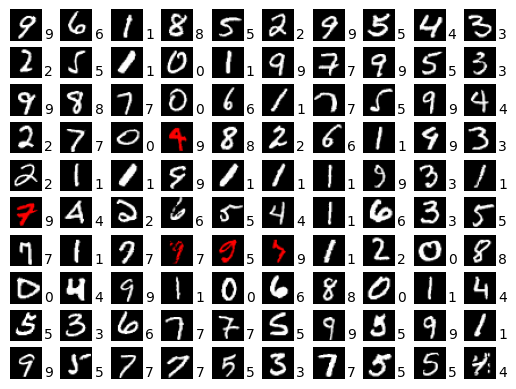

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.003688
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001498
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000459
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000715
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.001094
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001630
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.023068
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.045204
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.038443
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.008602

Test set: Average loss: 0.0745, Accuracy: 9814/10000 (98.14%)



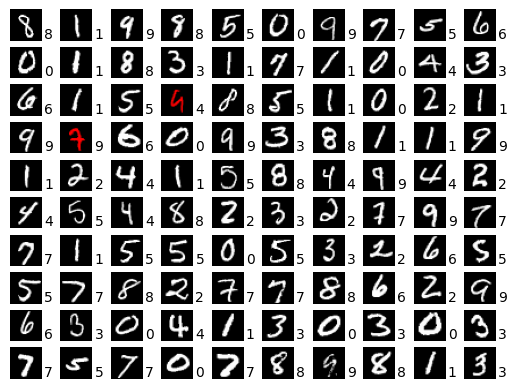

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.002520
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.046303
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.003388
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.001251
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000570
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.006311
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000028
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.051060
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000123
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.011748

Test set: Average loss: 0.0740, Accuracy: 9830/10000 (98.30%)



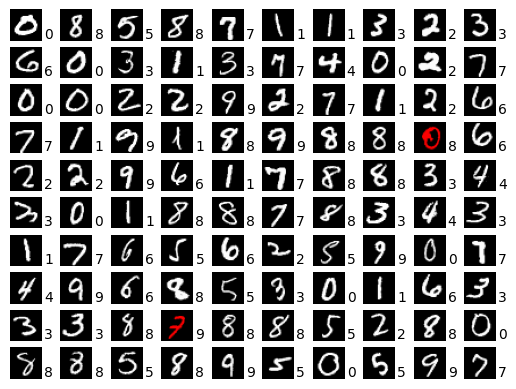

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.003173
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000126
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000436
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.005415
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000345
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.005175
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.007099
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000129
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000650
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000052

Test set: Average loss: 0.0745, Accuracy: 9831/10000 (98.31%)



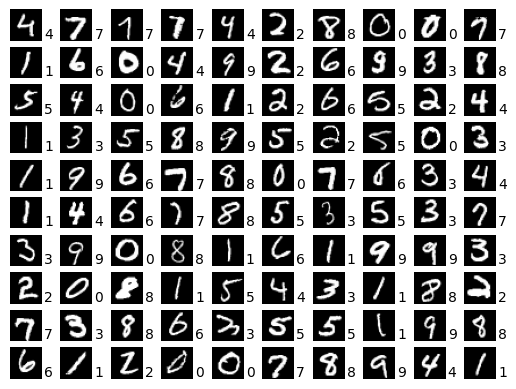

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001254
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.004114
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001345
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000374
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.014136
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000810
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.002609
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000650
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000472
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.006016

Test set: Average loss: 0.0768, Accuracy: 9830/10000 (98.30%)



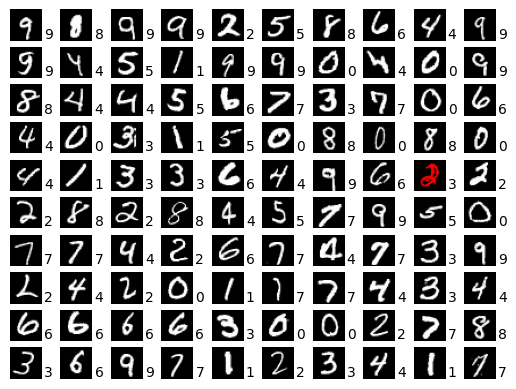

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000971
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.001332
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.003534
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.041150
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000044
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000304
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.009535
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.048254
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000745
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000492

Test set: Average loss: 0.0769, Accuracy: 9833/10000 (98.33%)



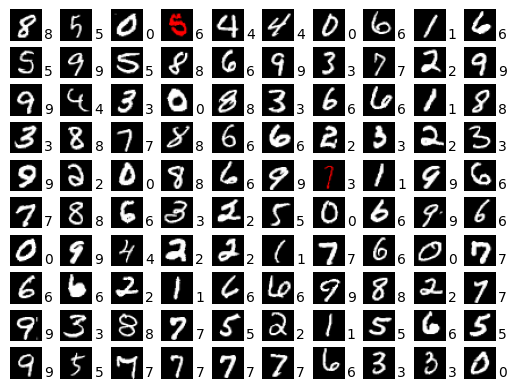

In [11]:
###=============================================================================
### Run MLP with relu non-linearity (By 10 epochs accuracy: 98.33%)
###=============================================================================
model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282964
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.259796
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.190562
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.505376
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.179892
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.207551
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.056690
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.124017
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.104548
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.065676

Test set: Average loss: 0.1047, Accuracy: 9673/10000 (96.73%)



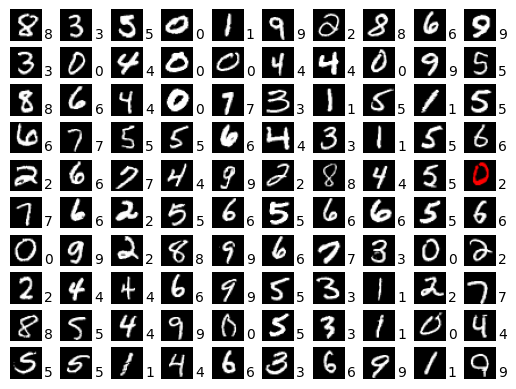

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037735
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.026069
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.015409
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.032601
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.082684
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.067213
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049024
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.070183
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.043985
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.010082

Test set: Average loss: 0.0821, Accuracy: 9753/10000 (97.53%)



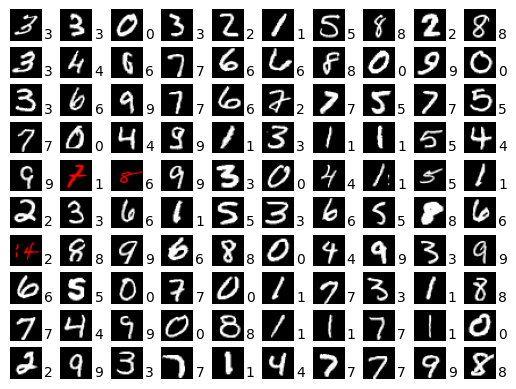

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.011242
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.023628
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.076260
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003694
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.041441
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.117869
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.078226
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.065732
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.081331
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.071369

Test set: Average loss: 0.0687, Accuracy: 9800/10000 (98.00%)



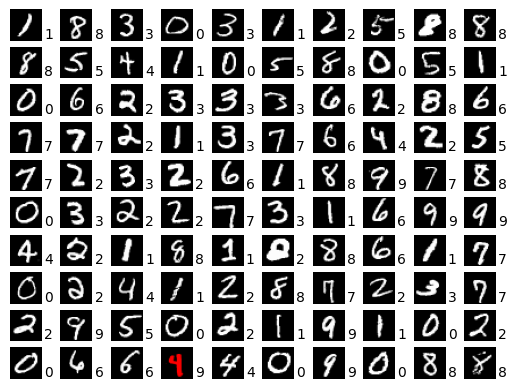

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.012220
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.140356
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.047652
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.116974
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.127968
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.017044
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.018903
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.007349
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.013079
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.038424

Test set: Average loss: 0.0608, Accuracy: 9835/10000 (98.35%)



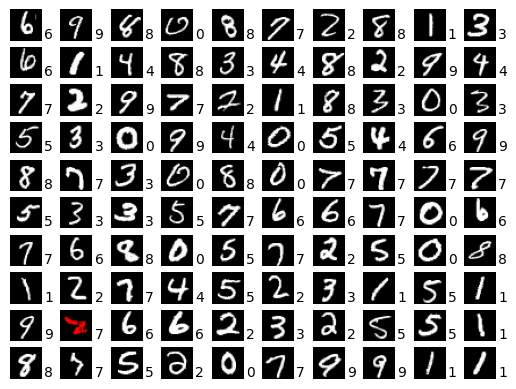

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.100336
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002237
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.051464
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.017562
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.090148
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.054348
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.003473
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.092073
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.044308
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.024877

Test set: Average loss: 0.0598, Accuracy: 9843/10000 (98.43%)



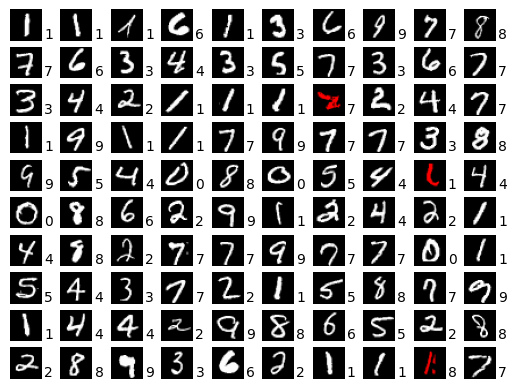

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.007461
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.008768
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.055888
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.037267
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.015435
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.003848
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000303
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.019961
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.004022
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.018031

Test set: Average loss: 0.0595, Accuracy: 9833/10000 (98.33%)



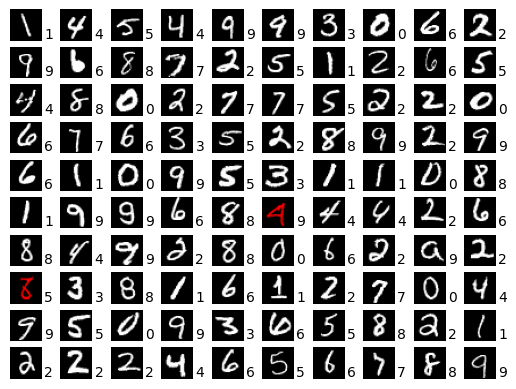

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.014292
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000536
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.015007
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.001814
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.003850
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.003942
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000726
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.002786
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.003957
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.006437

Test set: Average loss: 0.0603, Accuracy: 9833/10000 (98.33%)



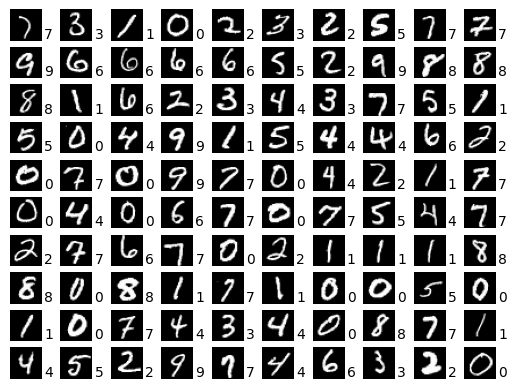

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.004670
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.003828
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000378
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.045938
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.027310
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.004744
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.002155
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001439
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.027417
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.013932

Test set: Average loss: 0.0611, Accuracy: 9845/10000 (98.45%)



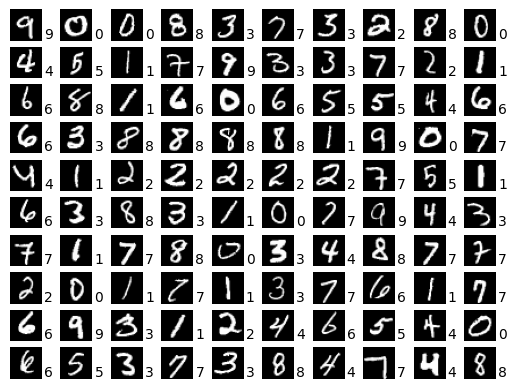

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.013670
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.004473
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.003810
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.003106
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.091264
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.042670
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.007512
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.003239
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001557
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.004189

Test set: Average loss: 0.0615, Accuracy: 9838/10000 (98.38%)



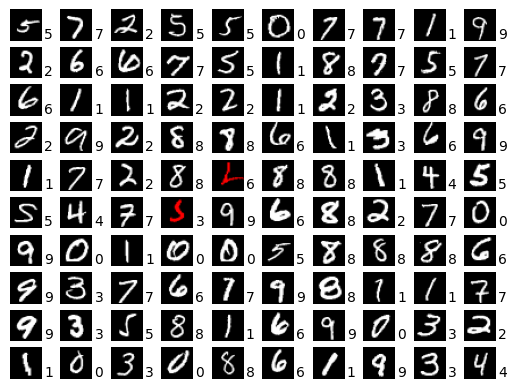

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.004872
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.002385
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.019300
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.010159
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.021834
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000268
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.001339
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000273
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000926
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.015870

Test set: Average loss: 0.0601, Accuracy: 9849/10000 (98.49%)



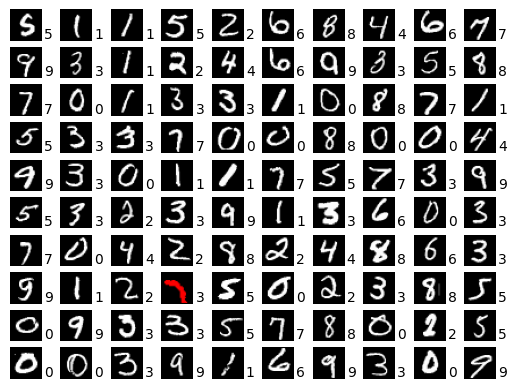

In [12]:
###========================================================================================
### Run MLP with relu non-linearity and batch normalization (By 10 epochs accuracy: 98.49%)
###=========================================================================================
model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

#### Run CNN

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303013
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.225910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.200891
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.097758
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.145526
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.064399
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.026411
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.089899
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.035633
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.007680

Test set: Average loss: 0.0614, Accuracy: 9813/10000 (98.13%)



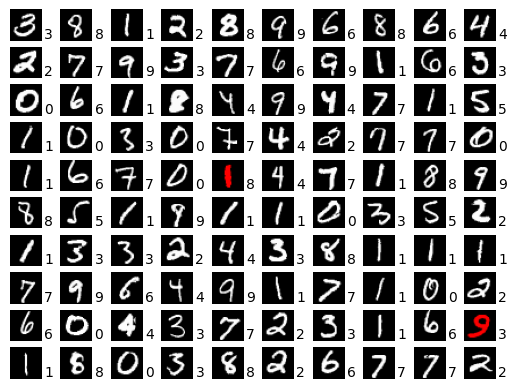

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.018008
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.026528
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.001501
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.013253
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.005833
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.090741
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034895
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.030078
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.002212
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.065763

Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)



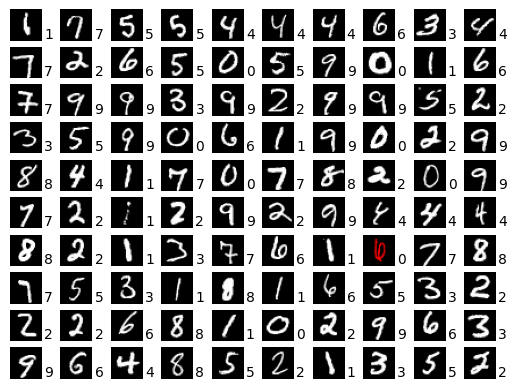

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027894
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.008581
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.020632
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.014475
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017835
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001815
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.012064
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.003855
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.001186
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.001557

Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)



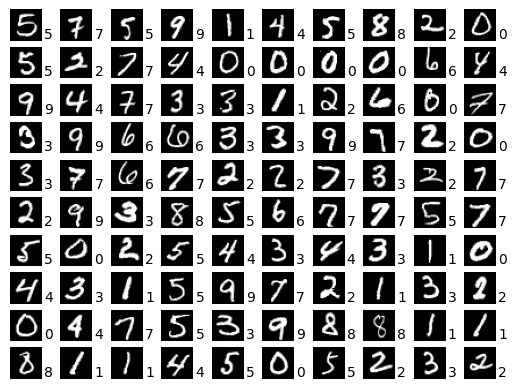

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000604
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.021531
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000234
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001412
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.004143
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000860
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000101
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000190
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001819
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.052104

Test set: Average loss: 0.0314, Accuracy: 9917/10000 (99.17%)



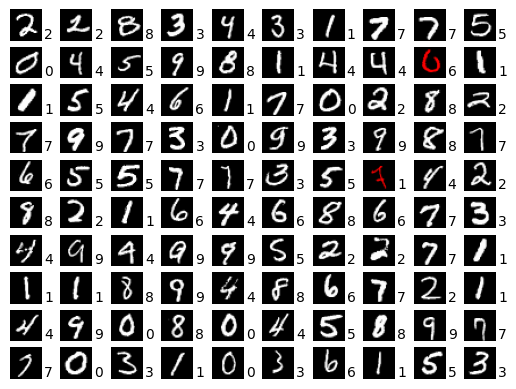

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000370
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002126
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.006768
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000082
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000487
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001926
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000332
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.001345
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000821
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000593

Test set: Average loss: 0.0323, Accuracy: 9913/10000 (99.13%)



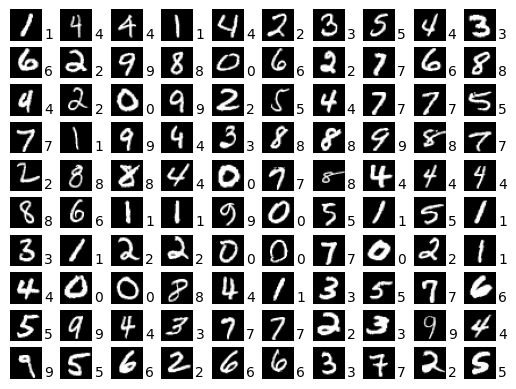

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000605
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000040
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000121
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000061
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000456
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000191
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000210
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000026
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000947
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000213

Test set: Average loss: 0.0332, Accuracy: 9915/10000 (99.15%)



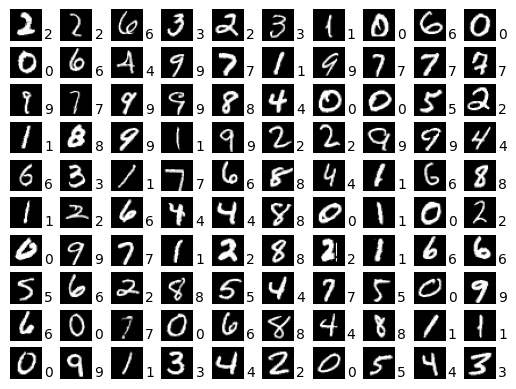

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000192
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000027
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.182178
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000127
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.001800
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000500
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000188
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000206
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000008
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000189

Test set: Average loss: 0.0339, Accuracy: 9916/10000 (99.16%)



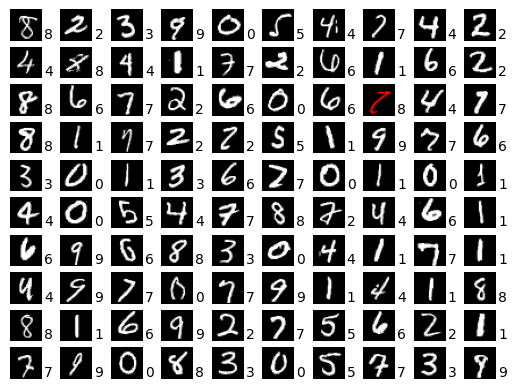

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000003
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000230
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.004858
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000385
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000010
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000144
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000068
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000910
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000095
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000617

Test set: Average loss: 0.0354, Accuracy: 9913/10000 (99.13%)



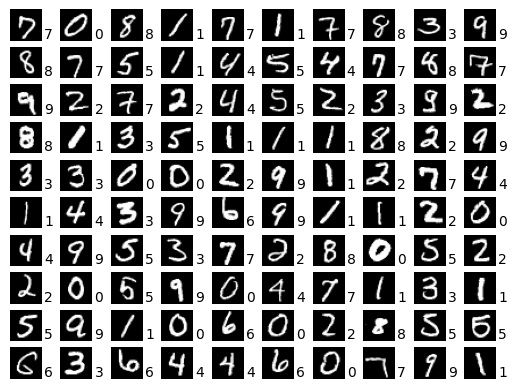

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000030
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000055
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000115
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000746
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000057
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000353
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000588
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000402
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000120
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000207

Test set: Average loss: 0.0354, Accuracy: 9917/10000 (99.17%)



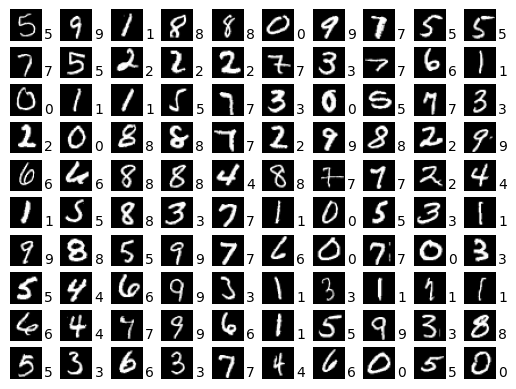

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000229
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000009
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000836
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000207
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000051
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000408
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000046
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000057
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000256
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000096

Test set: Average loss: 0.0355, Accuracy: 9915/10000 (99.15%)



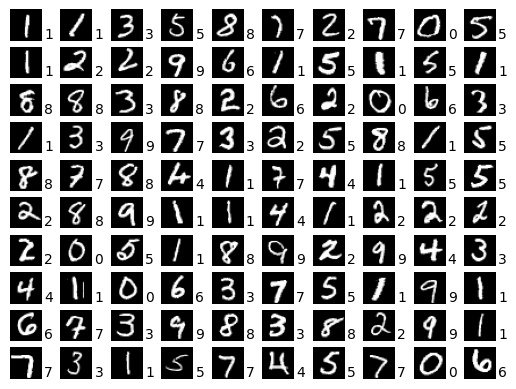

In [ ]:
###========================================================================================
### Run CNN (By 10 epochs accuracy: 99.15%)
###=========================================================================================
model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.381447
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.153047
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.038055
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.083824
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.025026
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.033293
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.032074
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.008100
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028894
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.049830

Test set: Average loss: 0.0452, Accuracy: 9858/10000 (98.58%)



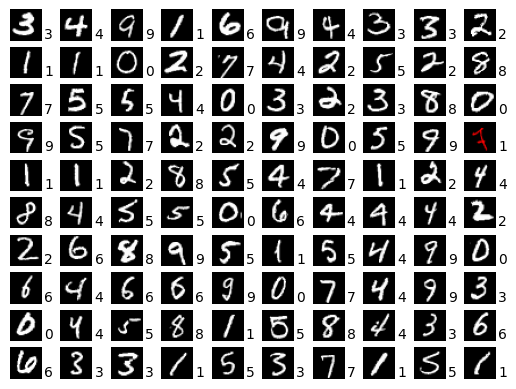

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023293
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.004172
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.005881
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.002510
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001513
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.016735
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.041087
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.003982
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020974
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.011337

Test set: Average loss: 0.0325, Accuracy: 9885/10000 (98.85%)



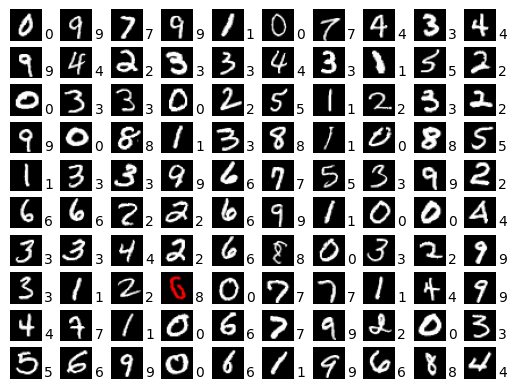

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006125
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.046114
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001662
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003333
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.001148
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.003359
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.007425
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.005620
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003990
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.019750

Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)



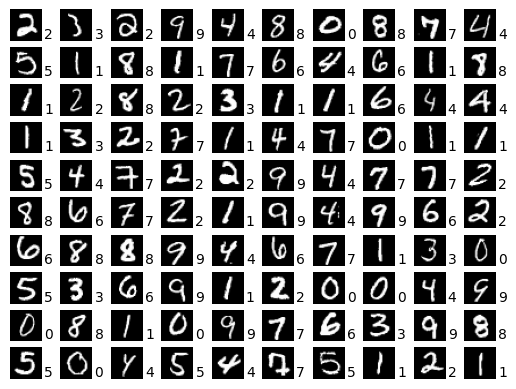

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.016398
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001070
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.004222
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.015484
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000636
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.005129
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000560
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.002297
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001357
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.011715

Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)



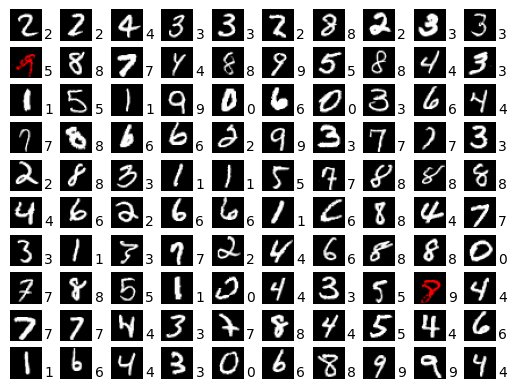

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.013716
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.004161
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.008501
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002173
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000690
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000337
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.004034
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000331
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.002284
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001678

Test set: Average loss: 0.0239, Accuracy: 9919/10000 (99.19%)



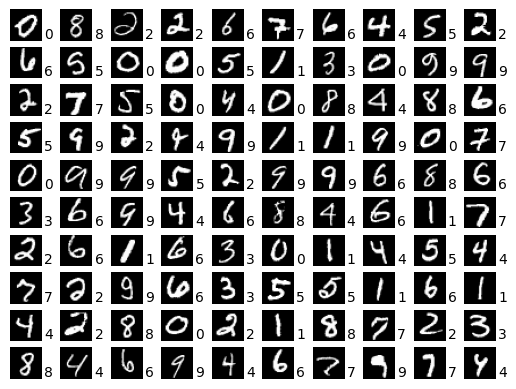

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.005462
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000779
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000671
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.001147
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.002093
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.001108
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.010793
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000210
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000879
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.009919

Test set: Average loss: 0.0239, Accuracy: 9913/10000 (99.13%)



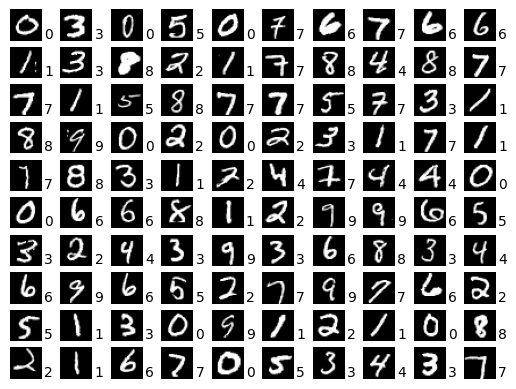

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000381
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.007277
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000681
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.004372
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000872
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.001287
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000685
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000850
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.001457
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.002300

Test set: Average loss: 0.0232, Accuracy: 9920/10000 (99.20%)



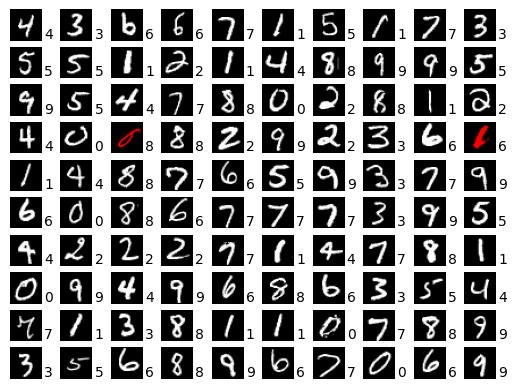

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000728
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000707
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000905
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.001845
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.003097
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000341
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000847
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000194
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000569
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000408

Test set: Average loss: 0.0238, Accuracy: 9916/10000 (99.16%)



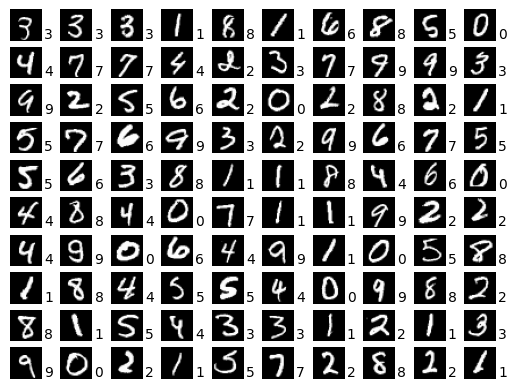

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000769
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.003408
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.012729
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000359
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000190
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000275
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000591
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000159
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000267
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000987

Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.20%)



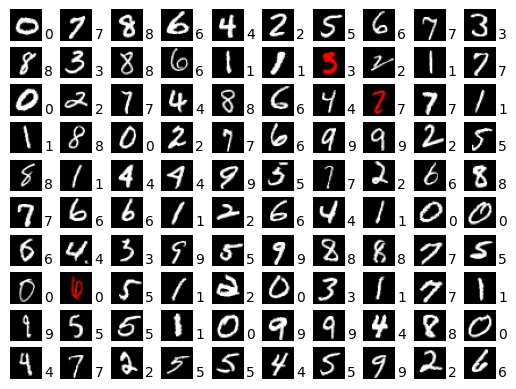

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000542
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.001238
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001072
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000534
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.002252
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.002986
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000153
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000517
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.002726
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.001024

Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)



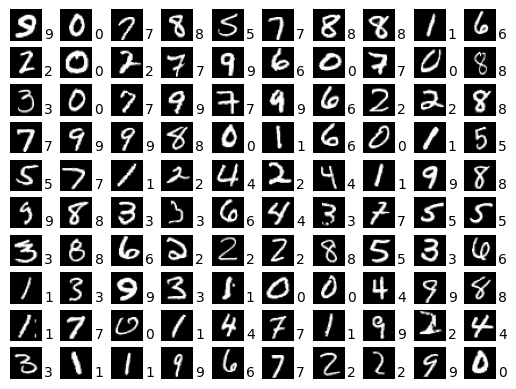

In [ ]:
###========================================================================================
### Run CNN with batch normalization (By 10 epochs accuracy: 99.19%)
###=========================================================================================
model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.435706
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.080878
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.189416
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.022661
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.118625
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.093820
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.043656
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.021634
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.163639
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.031130

Test set: Average loss: 0.0653, Accuracy: 9802/10000 (98.02%)



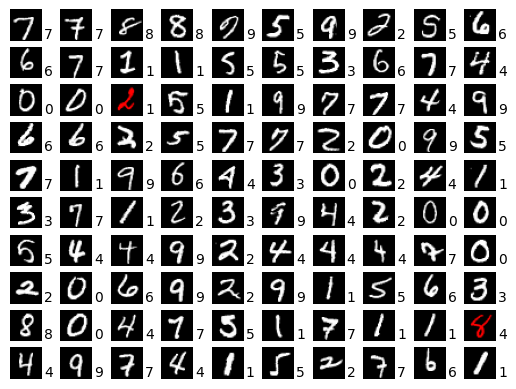

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.006024
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.019040
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.076360
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.016475
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.010601
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.020765
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.014049
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.028159
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.025727
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.001469

Test set: Average loss: 0.0339, Accuracy: 9881/10000 (98.81%)



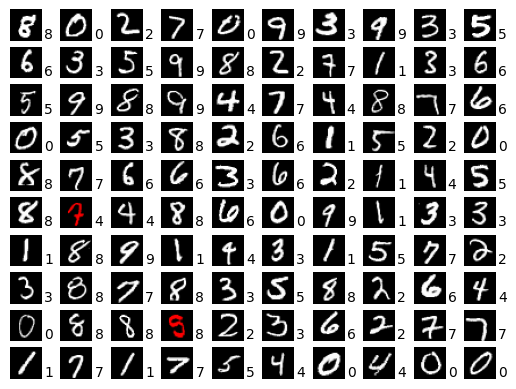

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.001797
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.008148
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.002025
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.008136
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.001312
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001252
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003061
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.002666
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.038797
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.014836

Test set: Average loss: 0.0302, Accuracy: 9904/10000 (99.04%)



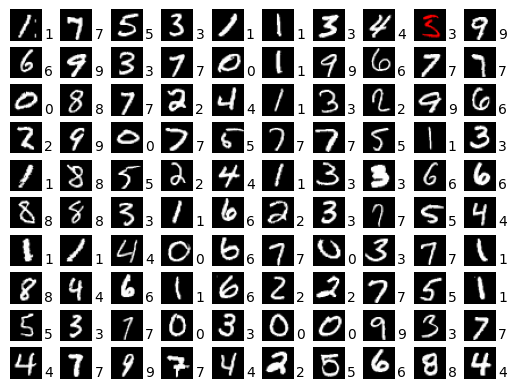

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.029586
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000819
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.003385
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.002216
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.003172
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001888
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.002620
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.003624
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.004496
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000442

Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)



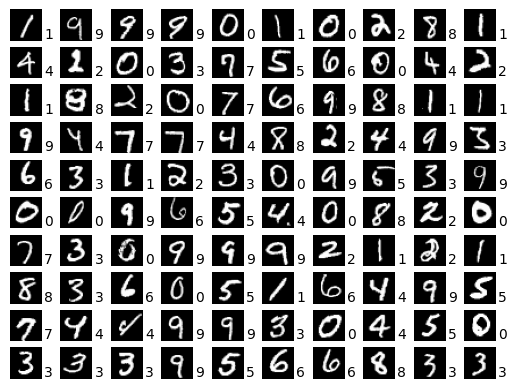

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000158
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.001496
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001992
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001143
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.007190
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.005938
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000891
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.002170
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.005523
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.019308

Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)



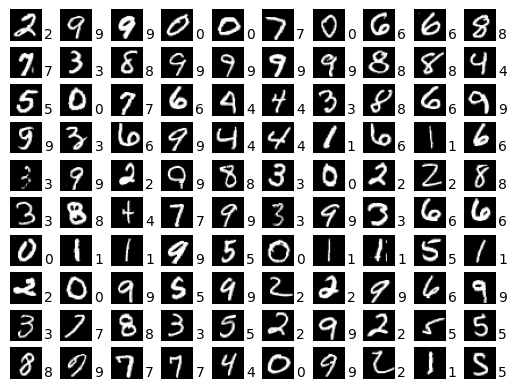

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000463
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.002101
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000730
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000677
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000586
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000494
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000205
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000395
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.003278
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.004561

Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)



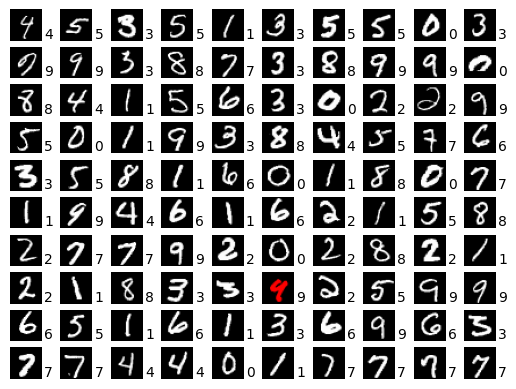

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000241
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000133
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.006520
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.001259
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.006814
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000237
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000519
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.001891
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002501
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000870

Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)



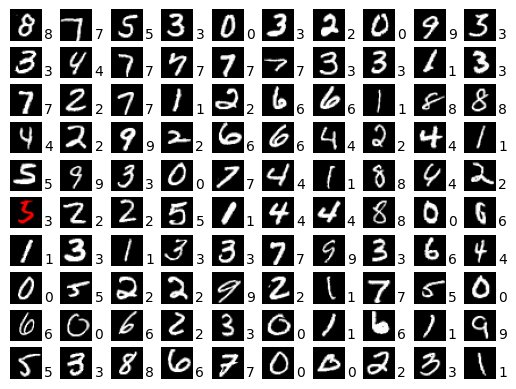

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.004122
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000911
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000279
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.029687
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000273
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.006182
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.009645
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001128
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000801
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.001172

Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)



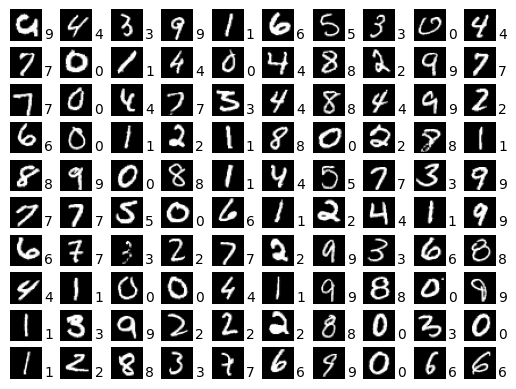

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001125
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000418
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001599
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001707
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001378
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000271
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.003088
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.006385
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.007349
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000378

Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)



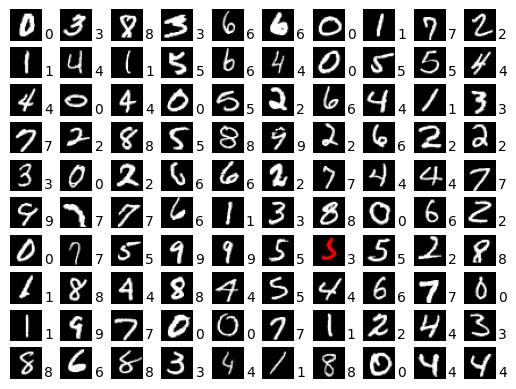

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.004190
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000569
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000245
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.008346
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.004429
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000565
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.012901
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000408
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000742
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000523

Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)



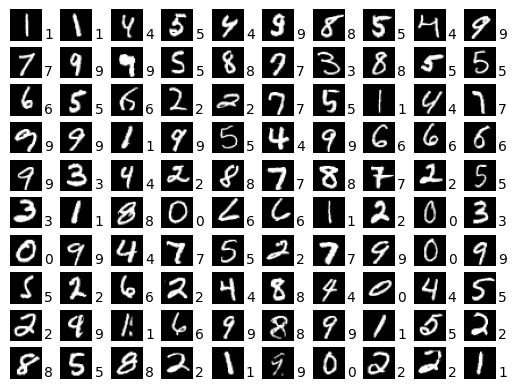

In [6]:
###========================================================================================
### Run CNN with maxpool and batch normalization (By 10 epochs accuracy: 99.23%)
###=========================================================================================
model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")